In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
from scipy import optimize
from scipy import *
import scipy
from scipy import stats
import tables
import h5py
import ODE_utils as odeu
from scipy.integrate import cumtrapz as trapint
import os
#import matplotlib.animation as animation
#!jt -t onedork -cellw 90%

### This code displays results for every function

This is a comprehensive code that is less focused but possibly the most useful code to get an over all picture of the results


In [2]:
uscal=1
vscal=1
extraterms=True
path="num-rel-pics/results4"
try:
    os.mkdir(path)
except:
    print("File already exists")

File already exists


uscal and vscal reduce arrays by their value in order to prevent memory overflow. Use when h5 files are very large (i.e. >2gB)

In [3]:
rnputil=np.load('rnputil.npy')
urange=np.load('urange.npy')[::uscal]
vrange=np.load('vrange.npy')[::vscal]

In [4]:
with h5py.File('rnp.h5','r') as f:
    r_group_key = list(f.keys())[0]
    rnpi=f[r_group_key]
    rnp = np.asarray(rnpi[::uscal,::vscal],dtype=np.float_)    
with h5py.File('signp.h5','r') as f:
    sig_group_key = list(f.keys())[0]
    signpi=f[sig_group_key]
    signp = np.asarray(signpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('phinp.h5','r') as f:
    phi_group_key = list(f.keys())[0]
    phinpi=f[phi_group_key]
    phinp = np.asarray(phinpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('massnp.h5','r') as f:
    mass_group_key = list(f.keys())[0]
    massnpi=f[mass_group_key]
    massnp = np.asarray(massnpi[::uscal,::vscal])
    
    
if extraterms==True:
    with h5py.File('drnpu.h5','r') as f:
        dru_group_key = list(f.keys())[0]
        drnpui=f[dru_group_key]
        drnpu = np.asarray(drnpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('drnpv.h5','r') as f:
        drv_group_key = list(f.keys())[0]
        drnpvi=f[drv_group_key]
        drnpv = np.asarray(drnpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dsignpu.h5','r') as f:
        dsigu_group_key = list(f.keys())[0]
        dsignpui=f[dsigu_group_key]
        dsignpu = np.asarray(dsignpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dsignpv.h5','r') as f:
        dsigv_group_key = list(f.keys())[0]
        dsignpvi=f[dsigv_group_key]
        dsignpv = np.asarray(dsignpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dphinpu.h5','r') as f:
        dphiu_group_key = list(f.keys())[0]
        dphinpui=f[dphiu_group_key]
        dphinpu = np.asarray(dphinpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dphinpv.h5','r') as f:
        dphiv_group_key = list(f.keys())[0]
        dphinpvi=f[dphiv_group_key]
        dphinpv = np.asarray(dphinpvi[::uscal,::vscal],dtype=np.float_)
    
    

print(str(rnp.nbytes)+" bytes")

print(rnp)

switchax=rnputil[9]
print(switchax)
if switchax==True:
    rnp=np.swapaxes(rnp,0,1)
    signp=np.swapaxes(signp,0,1)
    #phinp=np.swapaxes(phinp,0,1)
    #massnp=np.swapaxes(massnp,0,1)
    print("Switched Axes")

#print(massnp[1])
#print(rnp[:,4])

687040000 bytes
[[ 10.          10.0020203   10.00404069 ... 104.88977436 104.89222608
  104.89467779]
 [  7.97772975   7.97963489   7.98154016 ... 102.35843881 102.36088934
  102.36333986]
 [  5.9554595    5.95717713   5.95889498 ...  99.61859439  99.62104356
   99.62349273]
 ...
 [  1.46439171   1.46442164   1.4644516  ...  48.15173006  48.1541137
   48.15649734]
 [  1.46439171   1.46442164   1.4644516  ...  48.15038327  48.1527669
   48.15515054]
 [  1.46439171   1.46442164   1.4644516  ...  48.14903574  48.15141936
   48.153803  ]]
0.0


In [5]:
print(rnputil)



N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)

M=massnp[1][-1]
print(M,massnp[1,-1])

print('N='+str(N))

if M0>0.0:
    du0=M0/N
    dv0=du0
else:
    du0=1/N
    dv0=du0
    
#M=nan.max(massnp)

def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

if Lambda==0.0:
    sol = optimize.root(fr,[0.322,2.5],args=(M,Q,Lambda), method='hybr',tol=.0000001)
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=np.inf

if Lambda>0.0:
    sol = optimize.root(fr,[0.2,1.41,170],args=(M,Q,Lambda), method='hybr',tol=.0000001)
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=sol.x[2]
print('---')
print(M,Q,Lambda)
print('---')
print(0.0,rminus,rplus,rcosm)


['85880000' '2147' '40000' '10.0' '0.40405' '1.0' '0.9' '0.0' 'True' '0.0'
 'edd']
1.0167876511605336 1.0167876511605336
N=85880000
---
1.0167876511605336 0.9 0.0
---
0.0 0.5436522291590153 1.4899230731465514 inf


In [6]:
def kappa(fr,r,M,Q,Lambda):
    return 0.5*np.abs(scipy.misc.derivative(fr,r,dx=.00000001,n=1,args=(M,Q,Lambda)))
#def kappa2(dfr,r,M,Q,Lambda):
    #return optimize.root(dfr,[0.01,1.5,50.0],args=(M,Q,Lambda),tol=10**(-10), method='hybr')

kappaplus=kappa(fr,rplus,M,Q,Lambda)
kappaminus=kappa(fr,rminus,M,Q,Lambda)
kappacosm=kappa(fr,rcosm,M,Q,Lambda)
print('k+: '+str(kappaplus),'k-: '+str(kappaminus),'kc: '+str(kappacosm))
###double-check for Lambda=0
###kappaminus
#print(np.abs((M*rminus-Q**2)/rminus**3.0))
#print(0.5*np.abs(dfr(rminus,M,Q,Lambda)))
###

#print(kappaplus-kappacosm)


k+: 0.21313646680898302 k-: 1.6008222858410193 kc: nan


In [7]:
uval=5#Nu-1#for single value graphs, this chooses the index in the u direction
print(0,Nu)

0 2147


In [8]:
dercorr=1.0  #this is legacy, eddington coordinates are already correct      #dr0v/0.5/np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)
vrange2=vrange*dercorr
print(dercorr)

1.0


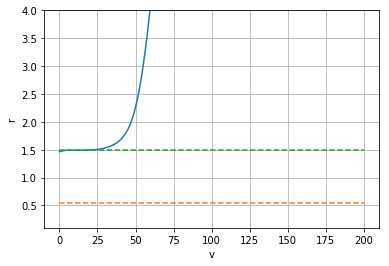

In [9]:
plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
if Lambda>0.0:
    plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')
#plt.ylim(rcosm-.0000001,rcosm+.0000001)
#plt.ylim(rminus-.001,rminus+.001)
plt.xlabel('v')
plt.ylabel('r')
plt.ylim(0.1,4.0)
#plt.yscale('log')
plt.grid()
plt.show()

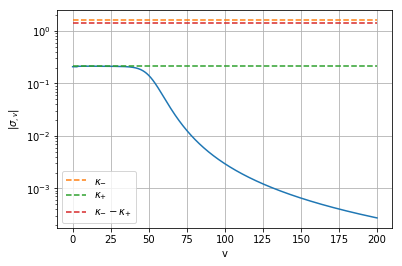

0.0002729229856057399 1.6008222858410193


In [10]:
plt.plot(vrange2,np.abs(dsignpv[uval])/dercorr)
#plt.plot(vrange2,np.abs(dsignpu[uval])/dercorr)
plt.plot([min(vrange2),max(vrange2)],[kappaminus,kappaminus],'--',label=r'$\kappa_{-}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappacosm,kappaminus-kappacosm],'--',label=r'$\kappa_{-}-\kappa_{c}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
plt.plot([min(vrange2),max(vrange2)],[kappaplus,kappaplus],'--',label=r'$\kappa_{+}$')
if Lambda>0.0:
    plt.plot([min(vrange2),max(vrange2)],[kappacosm,kappacosm],'--',label=r'$\kappa_{c}$')
    plt.plot([min(vrange2),max(vrange2)],[kappaminus-2*kappacosm,kappaminus-2*kappacosm],'--',label=r'$\kappa_{-}-2\kappa_{c}$')
plt.plot([min(vrange2),max(vrange2)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
#plt.plot([min(vrange),max(vrange)],[kappaplus-kappacosm,kappaplus-kappacosm],'--',label=r'$\kappa_{c}$')
plt.yscale('log')
#plt.ylim(1,2)
#plt.ylim(.4,1)
plt.xlabel('v')
plt.ylabel(r'|$\sigma_{,v}$|')
plt.legend(loc='best')
plt.grid()
plt.show()

print(np.abs(dsignpv[uval][-5]),kappaminus)

2147 40000
0.0 [2.73013448e-04 1.15518508e+01]
0.000272845402395932


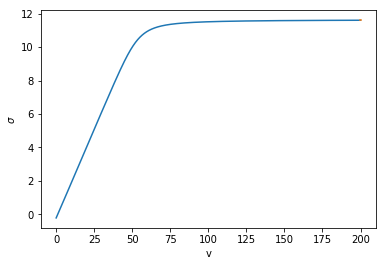

0.00027303942188398184
0.0 nan 1.6008222858410193 0.21313646680898302
0.0 nan
0.0 1.3876858190320362


In [11]:

print(Nu,Nv)
v1=Nv-20
v2=Nv-1
print(0.0,np.polyfit(vrange2[v1:v2],signp[uval][v1:v2],1.0))
print(dsignpv[uval][v2])

plt.plot(vrange2,signp[uval])
plt.plot(vrange2[v1:v2],signp[uval][v1:v2])
plt.xlabel('v')
plt.ylabel(r'$\sigma$')
plt.show()

print(np.abs(dsignpv[uval][int((v1+v2)/2)]))
print(0.0,kappacosm,kappaminus,kappaplus)
print(0.0,kappaminus-kappacosm)
print(0.0,kappaminus-kappaplus)

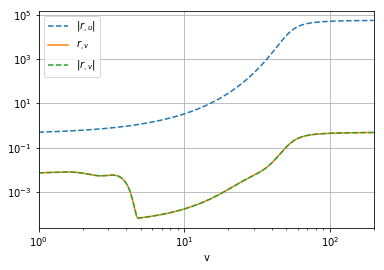

0 6.689733372503152e-05


In [12]:
plt.plot(vrange2,np.abs(drnpu[uval])/dercorr,'--',label=r'$|r_{,u}|$')
plt.plot(vrange2,drnpv[uval]/dercorr,label=r'$r_{,v}$')
plt.plot(vrange2,np.abs(drnpv[uval])/dercorr,'--',label=r'$|r_{,v}|$')
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.xlim(1,vmax)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('v')
#plt.ylabel(r'|$\sigma_{,v}$|')
plt.legend(loc='best')
plt.grid()
plt.show()

print(0,nanmin(drnpv[uval]))

40000 1.0
0.0 [ 0.05288974 -1.00772542]
0.0 [ 2.72285757e-04 -7.81935630e-01]
[ 0.05288974 -1.00772542]
[-5.17053609e-04  1.53318614e-01 -1.43645746e+00]


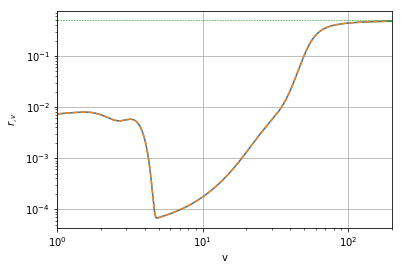

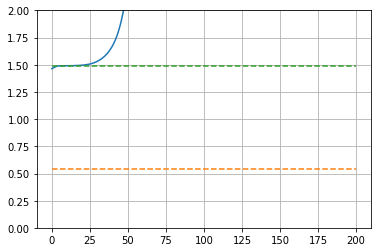

0.0 nan 0.21313646680898302 1.6008222858410193
1.3876858190320362
nan


In [13]:
v1=Nv-1800
v2=Nv-500#1200
print(Nv,dercorr)

print(0.0,np.polyfit(np.log(vrange2[v1:v2]),np.log(np.abs(drnpv[uval][v1:v2]/dercorr)),1.0))
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2]/dercorr)),1.0))

print(odeu.drdvparam(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2]))))
print(odeu.massparam(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2]))))
plt.plot(vrange2,drnpv[uval])
plt.plot(vrange2,np.abs(drnpv[uval]/dercorr),'--')
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.plot(vrange2[v1:v2],np.abs(drnpv[uval][v1:v2]/dercorr))
#plt.plot(vrange2[v1:v2-1],np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),'-.')
#plt.xlim(30,100)
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,vrange2[-1])
plt.xlabel('v')
plt.ylabel(r'$r_{,v}$')
plt.grid()
#plt.savefig('num-rel-pics/drdv_vs_v_EH.png',dpi=300)
plt.show()



plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
if Lambda>0.0:
    plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')

plt.grid()
plt.ylim(.001,2.0)
#plt.yscale('log')
plt.show()

#print(0.0,np.polyfit(np.log(vrange2[v1:v2-1]),np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),1.0))
print(0.0,kappacosm,kappaplus,kappaminus)
print(kappaminus-kappaplus)
print(kappaminus-kappacosm)

No handles with labels found to put in legend.


0.0 2147


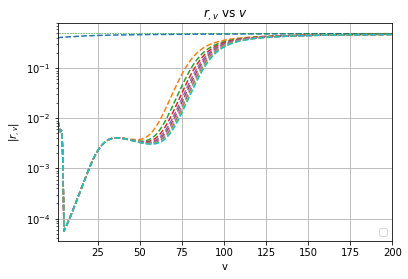

0.0 2147


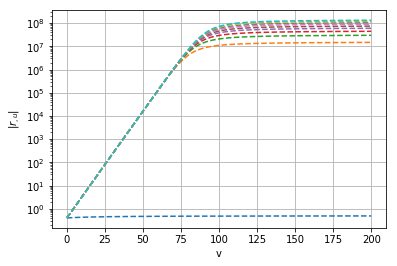

0.0 2147


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


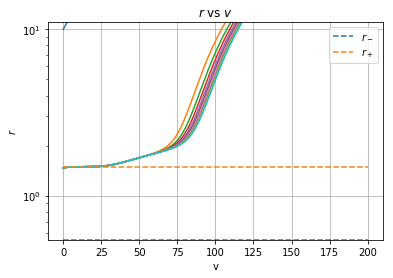

In [14]:
print(0.0,Nu)
numlines=10
ims=[]
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,(drnpv[i])/dercorr)
    plt.plot(vrange2,np.abs(drnpv[i])/dercorr,'--')
    #print(urange[i])
    #ims=ims.append([plt.imshow(np.abs(drnpv[i]),animated=True)])
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.plot([np.nan],[np.nan],'b',label=r'$r_{,v}$')
#plt.plot([np.nan],[np.nan],'b--',label=r'$|r_{,v}|$')
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.xlabel('v')
plt.ylabel(r'$|r_{,v}|$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(10,200)
plt.legend(loc='best')
plt.grid()
plt.title(r'$r_{,v}$ vs $v$')
plt.xlim(1,vmax)
#plt.ylim(10**(-7),10**0)
plt.savefig(path+'/drdv_vs_v.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(drnpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('v')
plt.ylabel(r'|$r_{,u}|$')

plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
plt.savefig(path+'/drdu_vs_v.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
ims=[]
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot((rnp[i]),vrange2)
    plt.plot(vrange2,np.abs(rnp[i])/dercorr)

#plt.axvline(rplus,linestyle='--',label=r'$r_+$')
#plt.axvline(rminus,'--',label=r'$r_-$')

plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--',label=r'$r_-$')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--',label=r'$r_+$')
plt.xlabel('v')
plt.ylabel(r'$r$')
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0,5.5)
plt.ylim(0,11)
plt.legend(loc='best')
plt.title(r'$r$ vs $v$')
plt.grid()
plt.savefig(path+'/r_vs_v.png',dpi=300)
plt.show()

199.9 199.95000000000002
0.0 [-2.68933206 -0.96367166]
nan


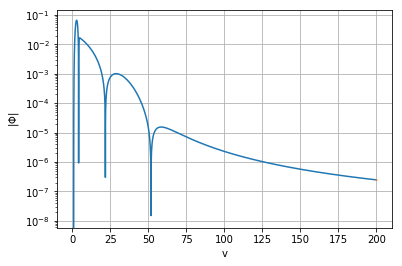

/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


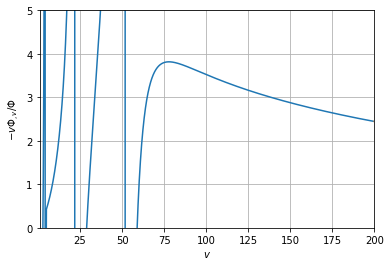

0.0 [0.00230517 0.03167162]


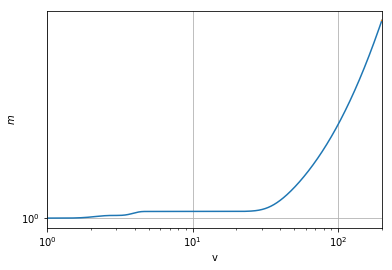

[-2.49720707e-03  9.60102852e-01 -4.09478302e+00]
1.6008222858410193


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [15]:
v1=Nv-20
v2=Nv-10
print(vrange2[v1],vrange2[v2])
print(0.0,np.polyfit(np.log(vrange2[v1:v2]),np.log(np.abs(phinp[uval][v1:v2])),1.0))
print(kappacosm)
plt.plot(vrange2,np.abs(phinp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(phinp[uval][v1:v2])/dercorr)
#plt.xlim(1,vrange2[-1])
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
#plt.xscale('log')
#plt.legend(loc='best')
plt.grid()
#plt.title('Phi along Event Horizon')
#plt.savefig('num-rel-pics/Phi vs v_bug_fixed.png',dpi=300)
plt.show()

plt.plot(vrange2,-vrange2*dphinpv[uval]/phinp[uval]/dercorr)
plt.plot(vrange2[v1:v2],-vrange2[v1:v2]*dphinpv[uval][v1:v2]/phinp[uval][v1:v2]/dercorr)
plt.ylim(0.0,5.0)
#plt.xscale('log')
plt.ylabel(r'$-v \Phi_{,v} /\Phi$')
plt.xlabel(r'$v$')
plt.xlim(1,vrange2[-1])
plt.grid()
#plt.savefig('num-rel-pics/Power of Phi vs v_bug_fixed.png',dpi=300)
plt.show()

numlines=10


print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[uval][v1:v2])),1.0))
plt.plot(vrange2,np.abs(massnp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(massnp[uval][v1:v2])/dercorr)
plt.xlim(1,vrange[-1])
plt.yscale('log')
plt.xlabel('v')
plt.xscale('log')
#plt.legend(loc='best')
plt.xlabel('v')
plt.ylabel(r'$m$')
plt.grid()
plt.savefig('num-rel-pics/Phi vs v.png',dpi=300)
plt.savefig(path+'/mass_vs_v.png',dpi=300)
plt.show()

print(odeu.massparam(vrange2[v1:v2],np.log(massnp[uval][v1:v2])))

print(kappaminus)

0.0 2147


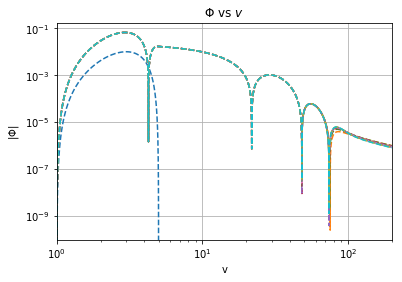

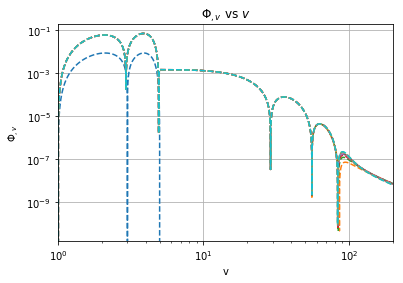

/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


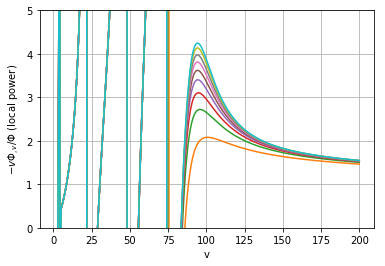

0.0 2147


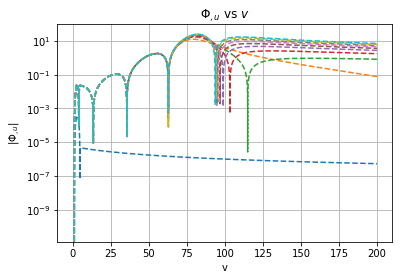

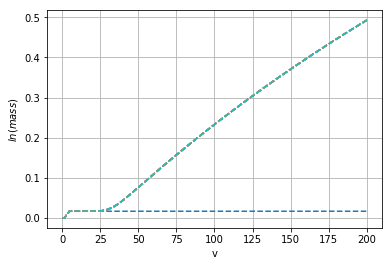

In [16]:
print(0.0,Nu)
numlines=10
for i in range(int(numlines*10/10)):
    i=int(i*Nu/numlines)
    
    plt.plot(vrange2,np.abs(phinp[i])/dercorr,'--')
    #print(urange[i])
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.xscale('log')
#plt.plot([np.nan],[np.nan],'b',label=r'$\Phi$')
#plt.plot([np.nan],[np.nan],'b--',label=r'$|\Phi|$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
plt.xlim(1,vmax)
#plt.xlim(.5,vrange2[-1])
plt.grid()
plt.title(r'$\Phi$ vs $v$')
#plt.legend()
#plt.savefig('num-rel-pics/Phis vs v-doulbeu.png',dpi=300)
plt.show()


#numlines=5
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,dphinpv[i]/dercorr)
    plt.plot(vrange2,np.abs(dphinpv[i])/dercorr,'--')
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
#plt.plot([np.nan],[np.nan],'b',label=r'$\Phi_{,v}$')
#plt.plot([np.nan],[np.nan],'b--',label=r'$|\Phi_{,v}|$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\Phi_{,v}$')
plt.xlabel('v')
plt.xlim(1,vmax)
plt.title(r'$\Phi_{,v}$ vs $v$')
plt.grid()
#plt.legend()
plt.savefig(path+'/dphidv vs v.png',dpi=300)
plt.show()

for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,-vrange2*dphinpv[i]/phinp[i]/dercorr)
    plt.ylim(0.0,5.0)
#plt.xscale('log')
plt.grid()
plt.ylabel(r'$-v \Phi_{,v} /\Phi$'+' (local power)')
plt.xlabel('v')
plt.savefig(path+'/Powers of Phi vs v.png',dpi=300)
plt.show()

print(0.0,Nu)
#numlines=5
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(dphinpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.ylabel(r'$|\Phi_{,u}|$')
plt.xlabel('v')
#plt.xlim(0,6)
plt.title(r'$\Phi_{,u}$ vs $v$')
plt.grid()
plt.savefig(path+'/dphidu vs v.png',dpi=300)
plt.show()

for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.log(massnp[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
#plt.yscale('log')
plt.ylabel(r'$ln(mass)$')
plt.xlabel('v')
#plt.xlim(0,6)
#plt.title(r'$\Phi_{,u}$ vs $v$')
plt.grid()
plt.savefig(path+'/masses vs v.png',dpi=300)
#plt.savefig('num-rel-pics/drdu_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_edd.png',dpi=300)
plt.show()

0.0 [ -0.02141886 -15.33330053]


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


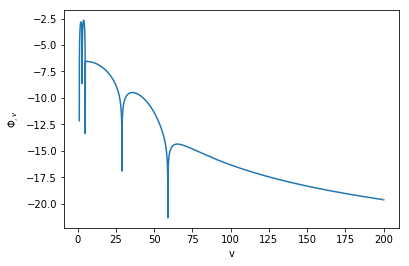

0.0 nan


In [17]:
v1=Nv-10
v2=Nv-1
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(dphinpv[uval][v1:v2]/dercorr)),1.0))
plt.plot(vrange2,np.log(np.abs(dphinpv[uval])))
plt.plot(vrange2[v1:v2],np.log(np.abs(dphinpv[uval][v1:v2])))
plt.xlabel('v')
plt.ylabel(r'$\Phi_{,v}$')
plt.show()
print(0.0,kappacosm)


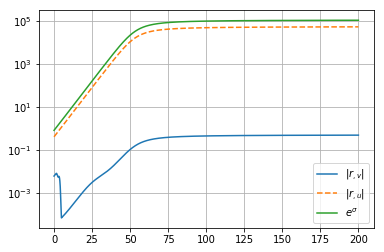

0 40000 1.6008222858410193
0.0 [0.00230517 0.03167162]


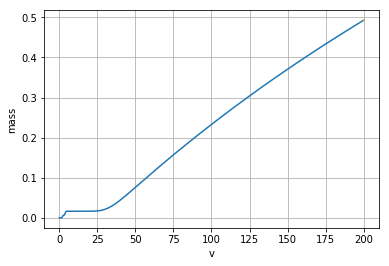

1.6008222858410193
nan


In [18]:
#plt.plot(vrange2,np.abs(massnp[uval]))
plt.plot(vrange2,np.abs(drnpv[uval]),label=r'$|r_{,v}|$')
plt.plot(vrange2,np.abs(drnpu[uval]),'--',label=r'$|r_{,u}|$')
plt.plot(vrange2,np.abs(np.exp(signp[uval])),label=r'$e^{\sigma}$')
#plt.ylim(massnp[uval,-1]-.00000000001,massnp[uval,-1]+.00000000001)
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(100,300)
plt.legend(loc='best')
plt.grid()
#plt.savefig('num-rel-pics/esig-drdv-drdu.png',dpi=300)
plt.show()

print(0,Nv,kappaminus)
v1=Nv-20
v2=Nv-10
uval2=uval
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[uval2][v1:v2])),1.0))
plt.plot(vrange2,np.log(np.abs(massnp[uval2])))
plt.plot(vrange2[v1:v2],np.log(np.abs(massnp[uval2][v1:v2])))
plt.xlabel('v')
plt.ylabel('mass')
plt.grid()
#plt.savefig('num-rel-pics/mass vs v-slope=.661-kappa-=.665.png',dpi=300)
plt.show()

print(kappaminus)
print(kappaminus-2*kappacosm)

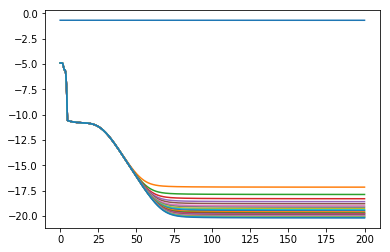

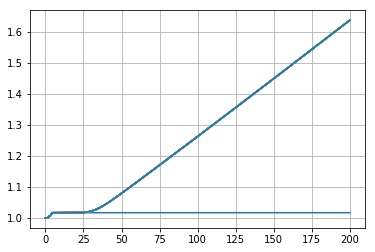

In [19]:
for i in range(int(Nu/100)):
    i2=100*i
    plt.plot(vrange,np.log(np.abs(np.exp(-signp[i2])*drnpv[i2])))#*drnpv[i2])))
plt.show()

for i in range(int(Nu/100)):
    i2=100*i
    plt.plot(vrange,massnp[i2])#*drnpv[i2])))
plt.grid()
plt.show()


40000
[-6.86853613e-05 -2.02556832e+01]


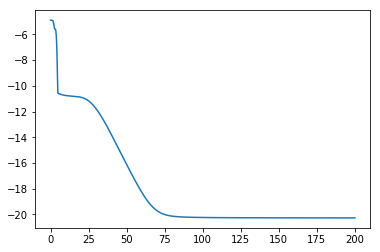

1.6008222858410193 nan 1.1745493522230532


In [20]:
print(Nv)
uval2=Nu-1
v1=Nv-20
v2=Nv-10
print(np.polyfit(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])),1.0))
plt.plot(vrange2,np.log(np.abs(np.exp(-signp[uval2])*drnpv[uval2])))
plt.plot(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])))
plt.show()

print(kappaminus,kappaminus-2*kappacosm,kappaminus-2*kappaplus)

In [21]:
print(massnp[0,-1])

1.0167876776090807


In [22]:
Rfunc=-drnpv[uval]*drnpu[uval]/rnp[uval]-np.exp(signp[uval])/(4.0*rnp[uval])*(1.0-np.power((Q/rnp[uval]),2.0)-Lambda*np.power(rnp[uval],2.0))

0.0 2147
4.999999999999916
21.12512838612854
21.125128604670248
21.12512867573022
21.125128710889935
21.12512873342679
21.125128745966187
21.125128757050074
21.125128763166853
21.125128769212505
21.125128774055884
21.125128777114274
21.125128780172663
21.12512878323105
21.125128785597
21.125128787126194
21.12512878865539
21.1251287901668
21.125128791695996
21.12512879322519
21.125128794248017
21.125128795165534
21.12512879608305
21.125128797000567
21.125128797918084


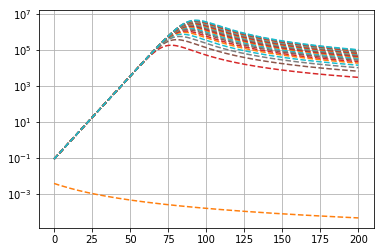

In [23]:
print(0.0,Nu)
numlines=25
for i in range(numlines):
    i=int(i*Nu/numlines)
    print(urange[i])
    Rfunc=-drnpv[i]*drnpu[i]/rnp[i]-np.exp(signp[i])/(4.0*rnp[i])*(1.0-np.power((Q/rnp[i]),2.0)-Lambda*np.power(rnp[i],2.0))
    #plt.plot(vrange2,Rfunc/dercorr)
    plt.plot(vrange2,(Rfunc))
    plt.plot(vrange2,np.abs(Rfunc),'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.grid()
plt.show()
#plt.plot(vrange2,Rfunc)
#plt.plot(vrange2,np.abs(Rfunc),'--')
#plt.yscale('log')
#plt.show


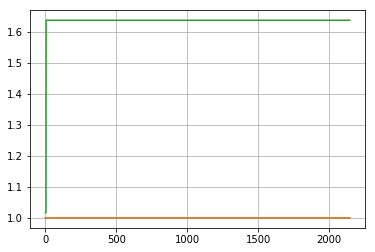

[[1.         1.         1.         ... 1.01678768 1.01678768 1.01678768]
 [1.         1.         1.         ... 1.01678765 1.01678765 1.01678765]
 [1.         1.         1.         ... 1.01678756 1.01678756 1.01678756]
 ...
 [0.99999991 0.99999991 0.99999991 ... 1.63668627 1.63670513 1.63672399]
 [0.99999991 0.99999991 0.99999991 ... 1.63668627 1.63670513 1.63672399]
 [0.99999991 0.99999991 0.99999991 ... 1.63668627 1.63670513 1.63672399]]


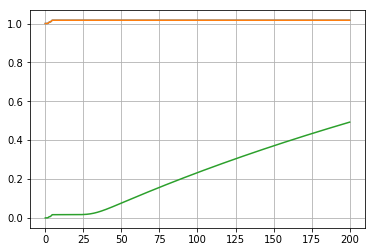

In [24]:
#plt.plot(urange,massnp[:,0])
#plt.plot(urange,massnp[:,1])
#plt.plot(urange,massnp[:,-1])
plt.plot(massnp[:,0])
plt.plot(massnp[:,1])
plt.plot(massnp[:,-1])
#plt.yscale('log')
plt.grid()
plt.show()
print(massnp)

plt.plot(vrange2,massnp[0])
plt.plot(vrange2,massnp[1])
plt.plot(vrange2,np.log(massnp[-10]))
#plt.yscale('log')
plt.grid()
plt.show()

In [25]:
print(len(rnp),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnp))
rnpf=np.delete(rnp,-1,axis=0)
massnpf=np.delete(massnp,-1,axis=0)
print(len(rnpf),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnpf))
Curvature=odeu.Kretsch(rnp,drnpv,drnpu,dphinpv,dphinpu,massnp,Q,Lambda)


2147 2147 2147 2147 2147 2147
2146 2147 2147 2147 2147 2146


MemoryError: 

In [ ]:
#plt.plot(vrange2,Curvature[30])
#plt.show()
Nuf=int(Nu*9/10)

print(0.0,Nuf)
numlines=30
for i in range(numlines):
    i=int(i*Nuf/numlines)
   
    plt.plot(vrange2,Curvature[i],'--')
plt.xlabel(r'$v$')
plt.ylabel(r'$K$')
plt.yscale('log')
plt.grid()
plt.title('Kretschman scalar')
#plt.savefig('num-rel-pics/K vs v.png',dpi=300)
plt.show()

print(rminus)
odeu.Kretsch(rminus,1,1,0,0,M0,Q,Lambda)

In [ ]:
plt.plot(rnp[uval],np.abs(phinp[uval]))
#plt.ylim(0,.0001)
#plt.xlim(min(rnp[uval])+.1,1)
plt.yscale('log')
plt.xlim(.1,2)
plt.xscale('log')
plt.show()

In [ ]:
print(drnpu)
print(drnpv)

### This last section is meant for Eddington Coordinates (u and v) only

In [ ]:
metricf=0.5*np.abs(1-2*massnp/rnp+Q**2.0/rnp**2.0-Lambda*rnp**2.0/3)

plt.plot(urange,0.5*np.exp(signp[:,0]),label=r'$e^{\sigma}$')
plt.plot(urange,np.abs(drnpu[:,0]),'--',label=r'$r_{,u}$')
plt.plot(urange,np.abs(drnpv[:,0]),label=r'$r_{,v}$')
plt.plot(urange,metricf[:,0],'--',label=r'Metric F')
#plt.plot(urange,np.abs(dsignpu[:,0]),label=r'$r_{,v}$')
#plt.xlim(99,100)
plt.yscale('log')
plt.xlabel('u')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $v_{0}$')
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_v0.png',dpi=300)
plt.show()


In [ ]:
plt.plot(urange,np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpv[:,0]))/(0.5*np.exp(signp[:,0]))*100)
plt.yscale('log')
plt.grid()
plt.show()

print((np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpv[:,0]))/(0.5*np.exp(signp[:,0])))[-1])

plt.plot(urange,np.abs(metricf[:,0]-0.5*np.exp(signp[:,0]))/(metricf[:,0])*100)
plt.yscale('log')
plt.grid()
plt.show()

print((np.abs(metricf[:,0]-0.5*np.exp(signp[:,0]))/(metricf[:,0]))[-1])

plt.plot(urange,np.abs(metricf[:,0]-np.abs(drnpv[:,0]))/(metricf[:,0])*100)
plt.yscale('log')
plt.grid()
plt.show()


plt.plot(urange,np.abs(0.5*np.exp(signp[:,0])-np.abs(drnpu[:,0]))/(0.5*np.exp(signp[:,0]))*100)
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(urange,np.abs(rnp[:,0]-rplus)/(rplus)*100)
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(urange,massnp[:,0])
plt.show()
print(massnp[0,0],massnp[1,0],massnp[2,0])

#print(rnp[:,0])
print(rnp[-1,0])
print(rplus)

In [ ]:
plt.plot(urange,0.5*np.exp(signp[:,-1]),label=r'$e^{\sigma}$')
plt.plot(urange,np.abs(drnpu[:,-1]),'--',label=r'$r_{,u}$')
plt.plot(urange,np.abs(drnpv[:,-1]),label=r'$r_{,v}$')
plt.plot(urange,0.5*np.abs(1-2*massnp[:,-1]/rnp[:,-1]+Q**2.0/rnp[:,-1]**2.0-Lambda*rnp[:,-1]**2.0/3),'--',label=r'Metric F')
#plt.plot(urange,np.abs(dsignpu[:,-1]),label=r'$r_{,v}$')
plt.yscale('log')
plt.yscale('log')
plt.xlabel('u')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $v_{max}=$'+str(vrange[-1]))
#plt.xlim(37.9396621,37.9396623)
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_vmax.png',dpi=300)
plt.show()

plt.plot(urange,np.abs(np.abs(drnpu[:,-1])-np.abs(drnpv[:,-1]))/(np.abs(drnpu[:,-1]))*100)
#plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
plt.plot(vrange,0.5*np.exp(signp[0]),label=r'$e^{\sigma}$')
plt.plot(vrange,np.abs(drnpu[0]),'--',label=r'$r_{,u}$')
plt.plot(vrange,np.abs(drnpv[0]),label=r'$r_{,v}$')
plt.plot(vrange,0.5*np.abs(1-2*massnp[0]/rnp[0]+Q**2.0/rnp[0]**2.0-Lambda*rnp[0]**2.0/3),'--',label=r'Metric F')
#plt.xlim(0,10)
plt.yscale('log')
plt.xlabel('v')
plt.grid()
plt.legend(loc='best')
plt.title(r'Functions along $u_{0}$')
#plt.savefig('num-rel-pics/esig_drdu_drdv_vs_u_u0.png',dpi=300)
plt.show()

plt.plot(vrange,np.abs(np.abs(drnpu[0])-np.abs(drnpv[0]))/(np.abs(drnpu[0]))*100)
#plt.yscale('log')
plt.grid()
plt.show()


In [ ]:
print(0.0,Nu,Nv)
numlines=20
for i in range(numlines):
    i=int(i*Nv/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(urange,dphinpu[:,i],'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.xlabel('u')
plt.ylabel(r'$\Phi_{,u}$')
#plt.xlim(0,6)
plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
#plt.savefig('num-rel-pics/dphidu_vs_u.png',dpi=300)
plt.show()

In [ ]:
print(Nv)
vval=Nv-1
u1=Nu-10
u2=Nu-5
print(0.0,np.polyfit(urange[u1:u2],np.log(np.abs(dphinpu[u1:u2,vval])),1.0))
plt.plot(urange,np.abs(dphinpu[:,vval]))
plt.plot(urange[u1:u2],np.abs(dphinpu[u1:u2,vval]))
plt.yscale('log')
#plt.xscale('log')
plt.grid()
plt.show()
print(kappacosm,kappaplus,kappaminus)
print()



In [ ]:
drnpvv=dsignpv[uval]*drnpv[uval]-rnp[uval]*(dphinpv[uval])**2.0
plt.plot(vrange2,vrange2*drnpvv/drnpv[uval])
plt.plot(vrange2,vrange2*dsignpv[uval],'--')
#-vrange2*dphinpv[i]/phinp[i]
#plt.plot(vrange2,-vrange2*drnpv[i]/rnp[i])
plt.grid()
#plt.yscale('log')
plt.ylim(-150,100)
plt.show()

drnpuu=dsignpu[:,vval]*drnpu[:,vval]-rnp[:,vval]*(dphinpu[:,vval])**2.0
plt.plot(urange,np.abs(urange*drnpuu/drnpu[:,vval]))
plt.plot(urange,np.abs(urange*dsignpu[:,vval]),'--')
#-vrange2*dphinpv[i]/phinp[i]
#plt.plot(vrange2,-vrange2*drnpv[i]/rnp[i])
plt.grid()
plt.yscale('log')
#plt.ylim(10**2,10**7)
plt.show()

In [ ]:
numlines=10
ims=[]
for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,np.abs(dsignpu[i])/dercorr)
    #plt.plot(vrange2,np.abs(rnp[i])/dercorr,'--')
    
#plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--',label=r'$r_-$')
#plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--',label=r'$r_+$')
plt.xlabel('v')
#plt.ylabel(r'$r$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,10)
plt.legend(loc='best')
#plt.title(r'$r$ vs $v$')
plt.grid()
#plt.savefig('num-rel-pics/r_vs_v.png',dpi=300)
plt.show()

In [ ]:
1/(rnp[uval])*dv0*-.5*odeu.trapint(drnpu[uval]*dphinpv[uval])

In [ ]:
N=10
umax2=5000
Nu2=int(umax2*N)
print(Nu2)
boundary=odeu.boundaryv(1,'edd','edd',Nu2,ru0,-dr0v,dv0,vmax,M0,Q,Lambda,False,0,10,float)
print(boundary[3])
print(boundary[6])

plt.plot(boundary[0])
plt.show()

plt.plot(np.abs(np.abs(boundary[3])-np.abs(boundary[6]))/boundary[6]*100)
plt.show()

In [ ]:
print(0.0,Nu)


plt.plot(vrange2,(drnpv[30])/dercorr)
plt.plot(vrange2,np.abs(drnpv[30])/dercorr,'--')
plt.plot(vrange2,(drnpv[150])/dercorr)
plt.plot(vrange2,np.abs(drnpv[150])/dercorr,'--')
plt.plot(vrange2,(drnpv[800])/dercorr)
plt.plot(vrange2,np.abs(drnpv[800])/dercorr,'--')
plt.plot(vrange2,(drnpv[Nu-250])/dercorr)
plt.plot(vrange2,np.abs(drnpv[Nu-250])/dercorr,'--')
plt.plot(vrange2,(drnpv[Nu-210])/dercorr)
plt.plot(vrange2,np.abs(drnpv[Nu-210])/dercorr,'--')
plt.plot(vrange2,(drnpv[Nu-1])/dercorr)
plt.plot(vrange2,np.abs(drnpv[Nu-1])/dercorr,'--')
   
plt.plot([np.nan],[np.nan],'b',label=r'$r_{,v}$')
plt.plot([np.nan],[np.nan],'b--',label=r'$|r_{,v}|$')
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.xlabel('v')
plt.ylabel(r'$r_{,v}$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(10,200)
plt.legend(loc='best')
plt.grid()
plt.title(r'$r_{,v}$ vs $v$')
#plt.savefig('num-rel-pics/drdv_vs_v-xlog.png',dpi=300)
plt.show()

In [ ]:
print(0.0,Nu)
plt.plot(vrange2,(phinp[30])/dercorr)
plt.plot(vrange2,np.abs(phinp[30])/dercorr,'--')
plt.plot(vrange2,(phinp[660])/dercorr)
plt.plot(vrange2,np.abs(phinp[660])/dercorr,'--')
plt.plot(vrange2,(phinp[2000])/dercorr)
plt.plot(vrange2,np.abs(phinp[2000])/dercorr,'--')
plt.plot(vrange2,(phinp[Nu-250])/dercorr)
plt.plot(vrange2,np.abs(phinp[Nu-250])/dercorr,'--')
plt.plot(vrange2,(phinp[Nu-210])/dercorr)
plt.plot(vrange2,np.abs(phinp[Nu-210])/dercorr,'--')
plt.plot(vrange2,(phinp[Nu-1])/dercorr)
plt.plot(vrange2,np.abs(phinp[Nu-1])/dercorr,'--')
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
#plt.xlim(.5,vrange2[-1])
plt.grid()
plt.title(r'$\Phi$ vs $v$')
#plt.savefig('num-rel-pics/Phis vs v.png',dpi=300)
plt.show()

In [ ]:
print(0.0,Nu)


plt.plot(vrange2,(drnpu[30])/dercorr)
plt.plot(vrange2,np.abs(drnpu[30])/dercorr,'--')
plt.plot(vrange2,(drnpu[150])/dercorr)
plt.plot(vrange2,np.abs(drnpu[150])/dercorr,'--')
plt.plot(vrange2,(drnpu[800])/dercorr)
plt.plot(vrange2,np.abs(drnpu[800])/dercorr,'--')
plt.plot(vrange2,(drnpu[Nu-250])/dercorr)
plt.plot(vrange2,np.abs(drnpu[Nu-250])/dercorr,'--')
plt.plot(vrange2,(drnpu[Nu-210])/dercorr)
plt.plot(vrange2,np.abs(drnpu[Nu-210])/dercorr,'--')
plt.plot(vrange2,(drnpu[Nu-1])/dercorr)
plt.plot(vrange2,np.abs(drnpu[Nu-1])/dercorr,'--')
   
plt.plot([np.nan],[np.nan],'b',label=r'$r_{,u}$')
plt.plot([np.nan],[np.nan],'b--',label=r'$|r_{,u}|$')
plt.plot([vrange2[0],vrange2[-1]],[.5,.5],'g--',linewidth=.5)
plt.xlabel('v')
plt.ylabel(r'$r_{,u}$')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(10,200)
plt.legend(loc='best')
plt.grid()
plt.title(r'$r_{,u}$ vs $v$')
#plt.savefig('num-rel-pics/drdu_vs_v.png',dpi=300)
plt.show()

In [ ]:
#drnpvf[] = -1/(4*drnpu[-1][0])*np.exp(signp[1][0])*(1-2*M0/rnp[1][0]+Q**2/rnp[1][0]**2-Lambda*rnp[1][0]**2/3)


In [ ]:
print(Nu)

uval3=348#-9000

print(rnp[uval3][0],rnp[uval3][-1])

dv=vrange[1]-vrange[0]

drnpvf = np.exp(signp[uval3])*(drnpv[uval3][0]*np.exp(-signp[uval3][0])-dv*trapint(rnp[uval3]*(dphinpv[uval3])**2.0*np.exp(-signp[uval3]),initial=0.0))
drnpvf2 =np.diff(rnp[uval3])/diff(vrange)

plt.plot(vrange,np.abs(drnpv[uval3]),label='Inegrated in u-direction')
plt.plot(vrange,np.abs(drnpvf),label='Inegrated in v-direction')
plt.plot(vrange[:-1],np.abs(drnpvf2),label='Numerical Derivative')
plt.ylim(10**(-11),10**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('v')
plt.ylabel(r'$|r_{,v}|$')
plt.grid()
plt.legend(loc='best')
#plt.savefig('num-rel-pics/drdu_comparison.png',dpi=300)
plt.show()

print(drnpvf[200],drnpv[uval3][200])

In [ ]:
trapint(,initial=0.0)

In [ ]:
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot((rnp[i]),vrange2)
    
    for j in range(Nv):
        
    
    plt.plot(vrange2,np.abs(rnp[i])/dercorr)